In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
import numpy as np
import datetime
import os, sys 
from matplotlib.pyplot import imshow, imsave
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# DEVICE = torch.device('cpu')

In [20]:
def get_sample_image(G, n_noise):
    """
        save sample 100 images
    """
    noise = torch.randn(3, 128,128).to(DEVICE)
    y_hat = G(noise).view(3, 128, 128) # (100, 28, 28)
    result = y_hat.cpu().data.numpy()
    # img = np.zeros([280, 280])
    # for j in range(10):
    #     img[j*128:(j+1)*128] = np.concatenate([x for x in result[j*10:(j+1)*10]], axis=-1)
    return result

In [21]:
get_sample_image

<function __main__.get_sample_image(G, n_noise)>

In [22]:
class Discriminator(nn.Module):
    """
        Simple Discriminator w/ MLP
    """
    def __init__(self, input_size, output_size):
        super(Discriminator, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.sigmoid = nn.Sigmoid()

        self.dropout2 = nn.Dropout(0.2)
        self.dropout3 = nn.Dropout(0.3)
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        
        
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1)
        self.batchnorm1 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,padding=1)
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3,padding=1)
        self.batchnorm2 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(1024)
        # self.maxpool3 = nn.AdaptiveMaxPool2d(512)
        

        
        self.l1 = nn.Linear(65536,512)
        self.l2 = nn.Linear(512,128)
        self.batchnorm4 = nn.LayerNorm(128)
        self.l3 = nn.Linear(128,output_size)




    def forward(self,input):
        #training pipeline

        conv = self.conv1(input)
        
        conv = self.conv2(conv)

        batchnorm = self.relu(self.batchnorm1(conv))
        maxpool = self.maxpool(batchnorm)

        conv = self.conv3(maxpool)
        conv = self.conv4(conv)

        batchnorm = self.relu(self.batchnorm2(conv))
        maxpool = self.maxpool(batchnorm)

        conv = self.conv5(maxpool)
        conv = self.conv6(conv)
        batchnorm = self.relu(self.batchnorm3(conv))
        maxpool = self.maxpool(batchnorm)
        maxpool = self.maxpool(maxpool)
    

              
        flatten = self.flatten(maxpool)
        
        #Neural Network Featuremap input
        dense_l1 = self.l1(flatten)
        dropout = self.dropout3(dense_l1)
        dense_l2 = self.l2(dropout)
        batchnorm = self.batchnorm4(dense_l2)
        dropout = self.dropout2(batchnorm)
        output = self.l3(dropout)
        output = self.sigmoid(output)
    
        return output

In [23]:
class Generator(nn.Module):
    """
        Simple Generator w/ MLP
    """
    def __init__(self, input_size=100, num_classes=128*128*3):
        super(Generator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, num_classes),
            nn.Tanh()
        )
        
    def forward(self, x):
        y_ = self.layer(x)
        y_ = y_.view(x.size(0), 3, 128, 128)
        return y_

In [24]:
n_noise = 128
D = Discriminator(input_size=128*128*3, output_size=1).to(DEVICE)
G = Generator(n_noise).to(DEVICE)
D.cuda()
G.cuda()

Generator(
  (layer): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=128, out_features=256, bias=True)
    (3): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Linear(in_features=256, out_features=512, bias=True)
    (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Linear(in_features=512, out_features=1024, bias=True)
    (9): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Linear(in_features=1024, out_features=49152, bias=True)
    (12): Tanh()
  )
)

In [25]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((128,128))])
mnist = datasets.Flowers102(root='../data/', transform=transform, download=True)

In [26]:
batch_size = 8
data_loader = DataLoader(dataset=mnist, batch_size=batch_size, shuffle=True, drop_last=True)
criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))
max_epoch = 50 # need more than 10 epochs for training generator
step = 0
n_critic = 0 # for training more k steps about Discriminator
D_labels = torch.ones(batch_size, 1).to(DEVICE) # Discriminator Label to real
D_fakes = torch.zeros(batch_size, 1).to(DEVICE) # Discriminator Label to fake

In [27]:
imshow(get_sample_image(G, n_noise))

RuntimeError: running_mean should contain 128 elements not 256

In [71]:
if not os.path.exists('samples'):
    os.makedirs('samples')
for epoch in range(max_epoch):
    for idx, (images, _) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        x_outputs = D(x)
        D_x_loss = criterion(x_outputs, D_labels)

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z))
        D_z_loss = criterion(z_outputs, D_fakes)
        D_loss = D_x_loss + D_z_loss
        
        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        if step % 1 == 0:
            # Training Generator
            z = torch.randn(batch_size, n_noise).to(DEVICE)
            z_outputs = D(G(z))
            G_loss = criterion(z_outputs, D_labels)

            G.zero_grad()
            G_loss.backward()
            G_opt.step()
        
        if step % 50 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))
        
        if step % 50 == 0:
            G.eval()
            img = get_sample_image(G, n_noise)
            imsave('samples/{}_step{}.jpg'.format("VanillaGAN", str(step).zfill(3)), img, cmap='gray')
            G.train()
            # imshow(get_sample_image(G, n_noise))
        step += 1

c:\Users\hosei\anaconda3\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


OutOfMemoryError: CUDA out of memory. Tried to allocate 192.00 MiB. GPU 0 has a total capacty of 4.00 GiB of which 0 bytes is free. Of the allocated memory 2.84 GiB is allocated by PyTorch, and 523.67 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

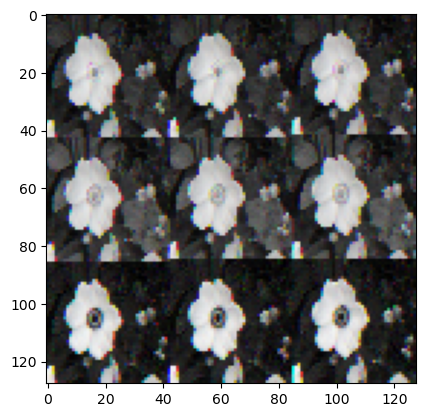

In [ ]:
dataiter = iter(data_loader)
images, labels = next(dataiter)
image = images[0]

# image.shape

# torch.Size([ 128, 128, 3]) # pyplot doesn't like this, so reshape

image = image.reshape(128,128,3)
imshow(image.numpy())

RuntimeError: running_mean should contain 128 elements not 256

In [72]:
input_tensor = torch.randn(1, 3, 224, 224)

In [73]:
show_images(input_tensor)

NameError: name 'show_images' is not defined

In [74]:
def denorm(img_tensor):
    return img_tensor 
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8,8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(torchvision.utils.make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2,0))
def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

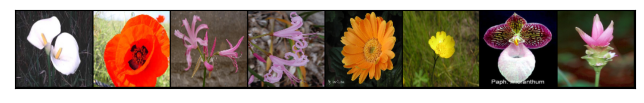

In [75]:
show_batch(data_loader)